# Bayesian Estimation Supersedes the T-Test

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

This model replicates the example used in:
Kruschke, John. (2012) **Bayesian estimation supersedes the t-test**. *Journal of Experimental Psychology*: General.

### The Problem

Several statistical inference procedures involve the comparison of two groups. We may be interested in whether one group is larger than another, or simply different from the other. We require a statistical model for this because true differences are usually accompanied by measurement or stochastic noise that prevent us from drawing conclusions simply from differences calculated from the observed data. 

The *de facto* standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (*e.g.* statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999). 

A more informative and effective approach for comparing groups is one based on **estimation** rather than **testing**, and is driven by Bayesian probability rather than frequentist. That is, rather than testing whether two groups are different, we instead pursue an estimate of how different they are, which is fundamentally more informative. Moreover, we include an estimate of uncertainty associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (epistemic uncertainty) and uncertainty due to the inherent stochasticity of the system (aleatory uncertainty).

## Example: Drug trial evaluation

To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

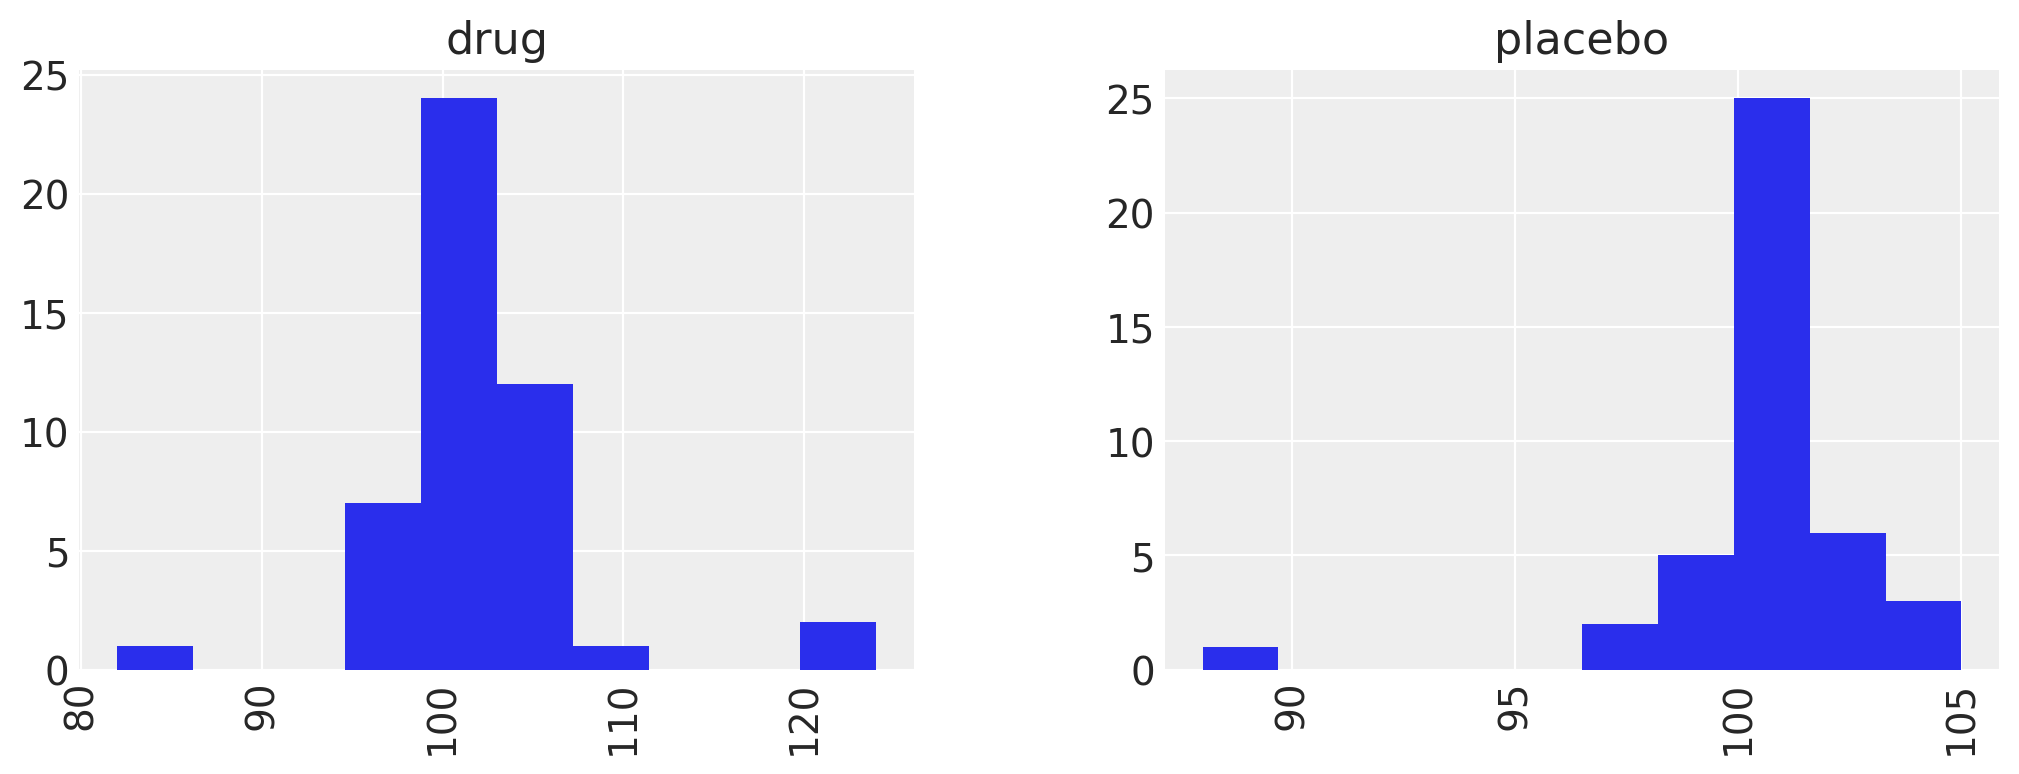

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group', figsize=(12, 4));

The first step in a Bayesian approach to inference is to specify the full probability model that corresponds to the problem. For this example, Kruschke chooses a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$y^{(treat)}_i \sim T(\nu, \mu_1, \sigma_1)$$

$$y^{(placebo)}_i \sim T(\nu, \mu_2, \sigma_2)$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. We will, of course, have separate parameters for the means $\mu_k, k=1,2$ and standard deviations $\sigma_k$.

Since the means are real-valued, we will apply normal priors on them, and arbitrarily set the hyperparameters to the pooled empirical mean of the data and twice the pooled empirical standard deviation, which applies very diffuse information to these quantities (and importantly, does not favor one or the other *a priori*).

$$\mu_k \sim N(\bar{x}, 2s)$$

In [4]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

The group standard deviations will be given a uniform prior over a plausible range of values for the variability of the outcome variable, IQ.

In Kruschke's original model, he uses a very wide uniform prior for the group standard deviations, from the pooled empirical standard deviation divided by 1000 to the pooled standard deviation multiplied by 1000. This is a poor choice of prior, because very basic prior knowledge about measures of human coginition dictate that the variation cannot ever be as high as this upper bound. IQ is a standardized measure, and hence this constrains how variable a given population's IQ values can be. When you place such a wide uniform prior on these values, you are essentially giving a lot of prior weight on inadmissable values. In this example, there is little practical difference, but in general it is best to apply as much prior information that you have available to the parameterization of prior distributions. 

We will instead set the group standard deviations to have a $\text{Uniform}(1,10)$ prior:

In [5]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

We follow Kruschke by making the prior for $\nu$ exponentially distributed with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

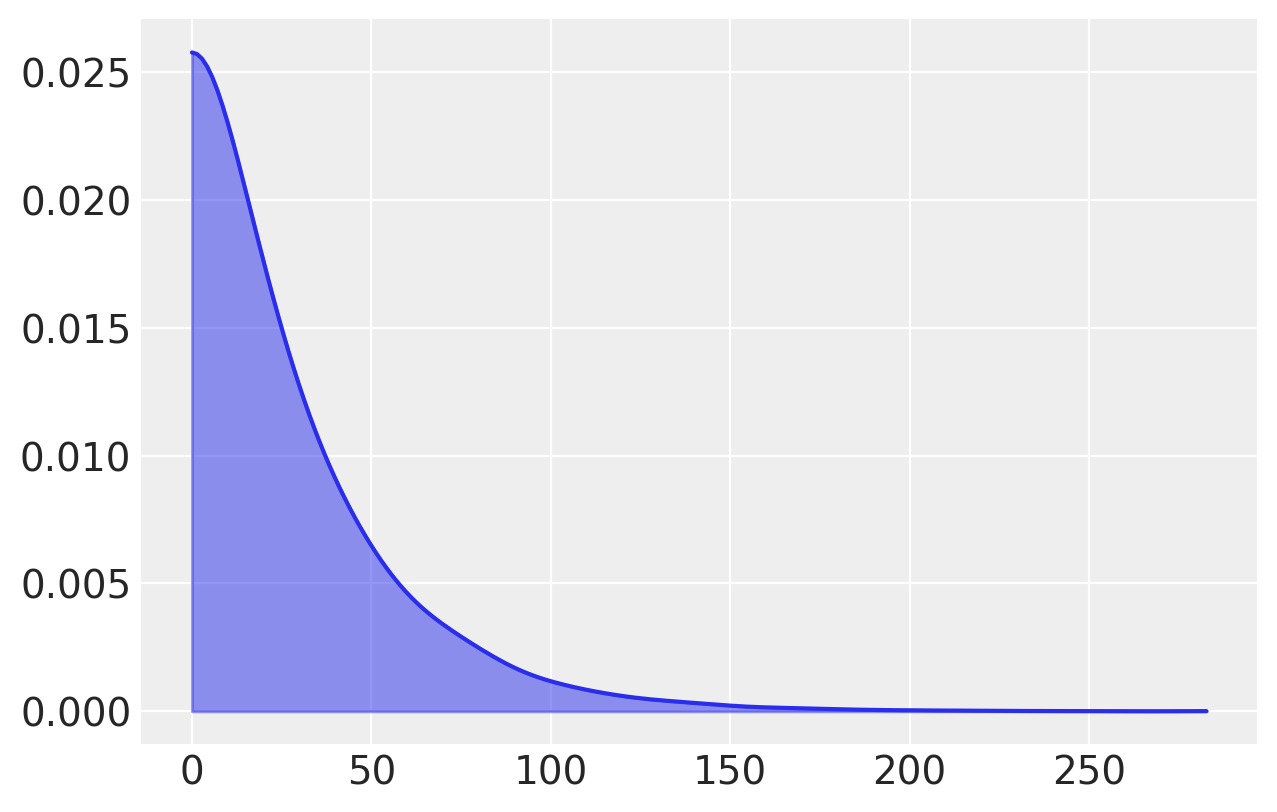

In [6]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, we must transform the standard deviations before specifying our likelihoods.

In [7]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of interest in order to evaluate the effect of the drug. To this end, we can specify deterministic nodes in our model for the difference between the group means and the difference between the group standard deviations. Wrapping them in named `Deterministic` objects signals to PyMC that we wish to record the sampled values as part of the output.

As a joint measure of the groups, we will also estimate the "effect size", which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but the quantity is a function of all four estimated parameters.

In [8]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


Now, we can fit the model and evaluate its output.

In [9]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


We can plot the stochastic parameters of the model. PyMC's `plot_posterior` function replicates the informative histograms portrayed in Kruschke (2012). These summarize the posterior distributions of the parameters, and present a 95% credible interval and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


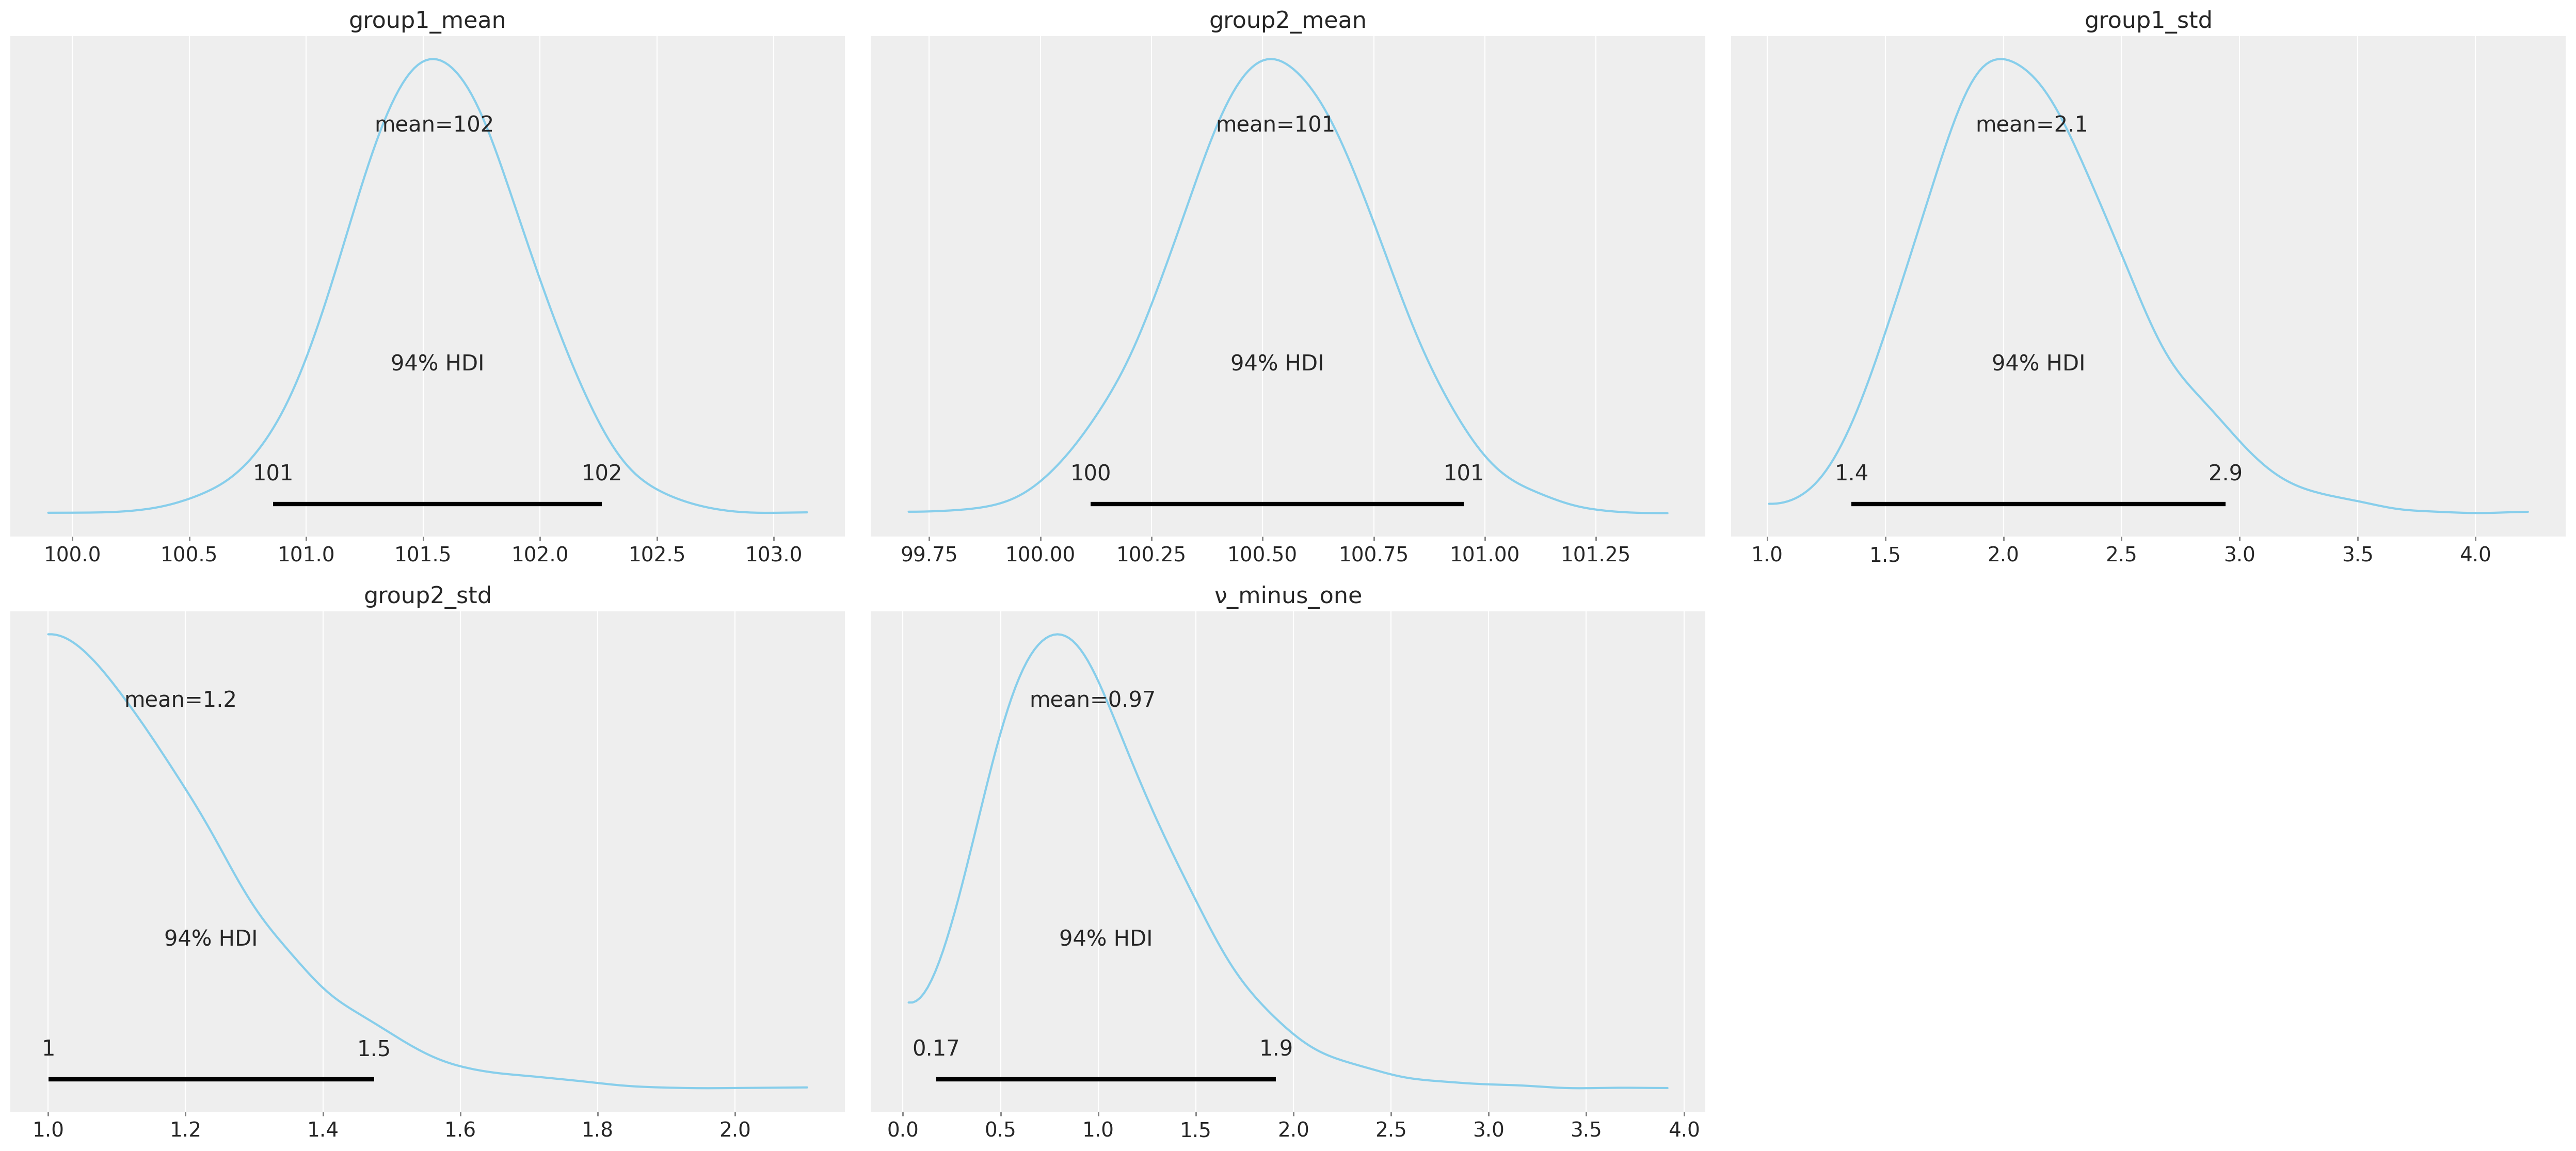

In [10]:
pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

Looking at the group differences below, we can conclude that there are meaningful differences between the two groups for all three measures. For these comparisons, it is useful to use zero as a reference value (`ref_val`); providing this reference value yields cumulative probabilities for the posterior distribution on either side of the value. Thus, for the difference of means, at least 97% of the posterior probability are greater than zero, which suggests the group means are credibly different. The effect size and differences in standard deviation are similarly positive.

These estimates suggest that the "smart drug" increased both the expected scores, but also the variability in scores across the sample. So, this does not rule out the possibility that some recipients may be adversely affected by the drug at the same time others benefit.

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


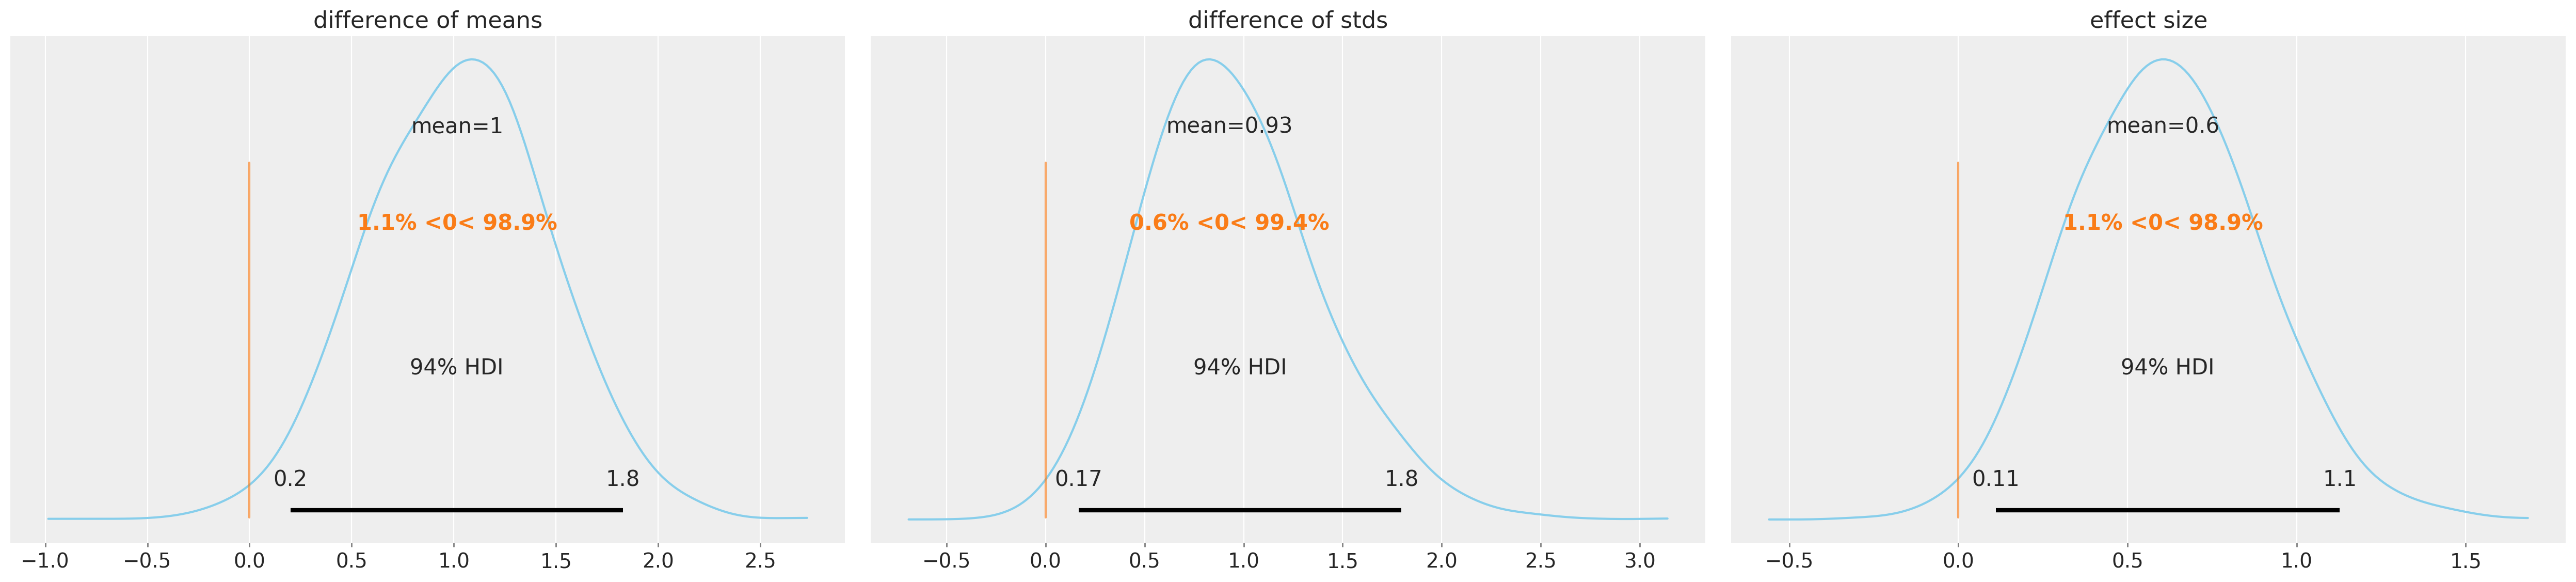

In [11]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

When `forestplot` is called on a trace with more than one chain, it also plots the potential scale reduction parameter, which is used to reveal evidence for lack of convergence; values near one, as we have here, suggest that the model has converged.

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


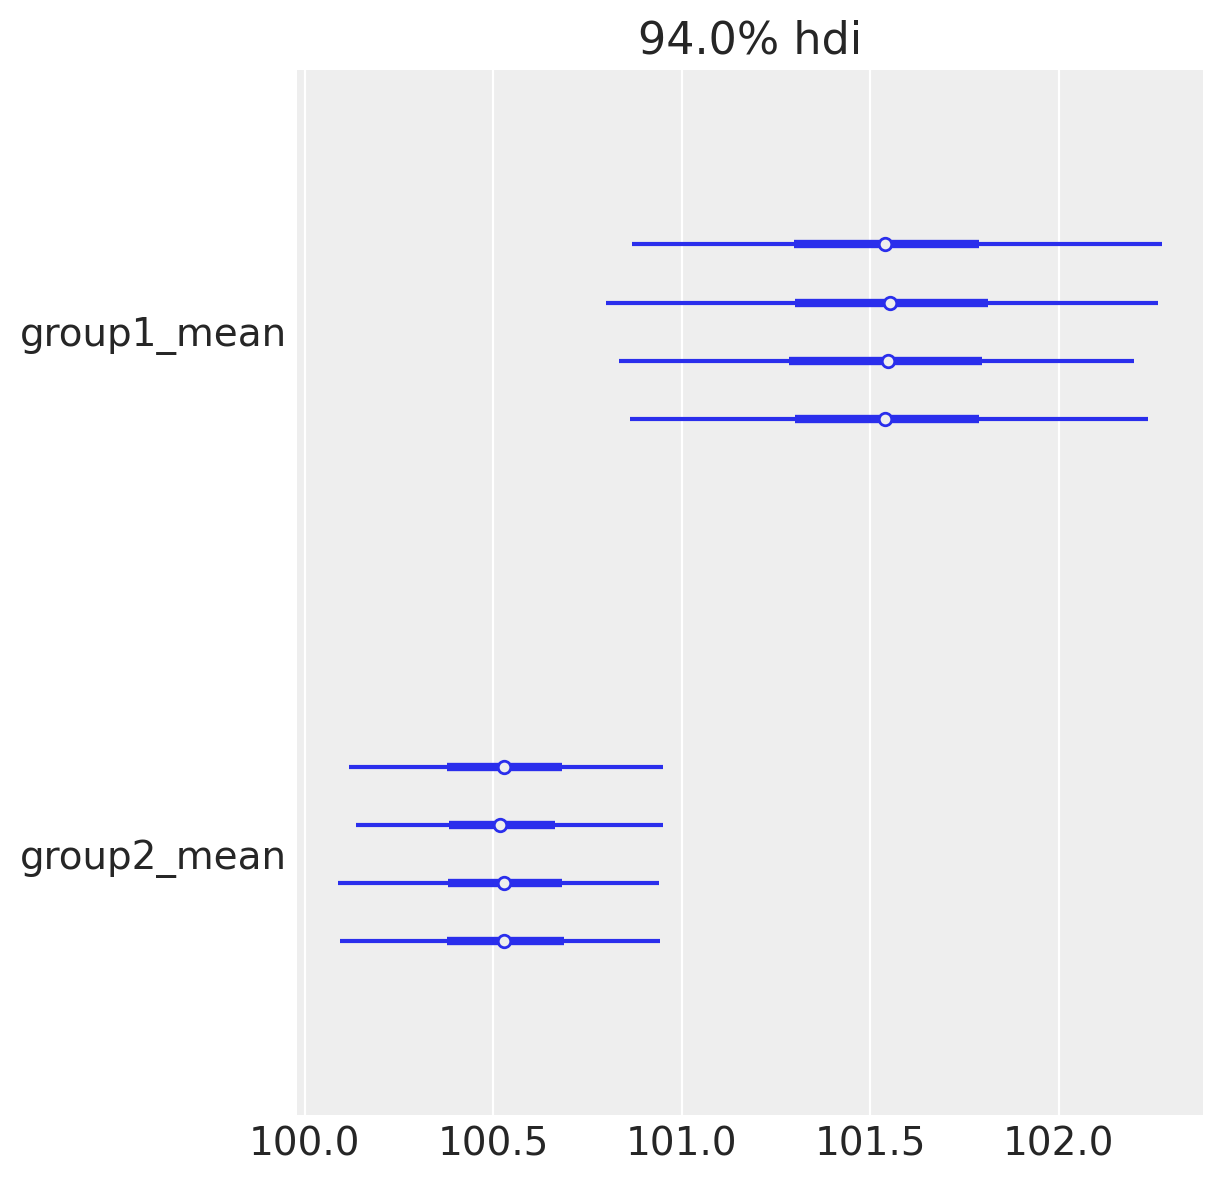

In [12]:
pm.forestplot(trace, var_names=['group1_mean',
                                'group2_mean']);

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


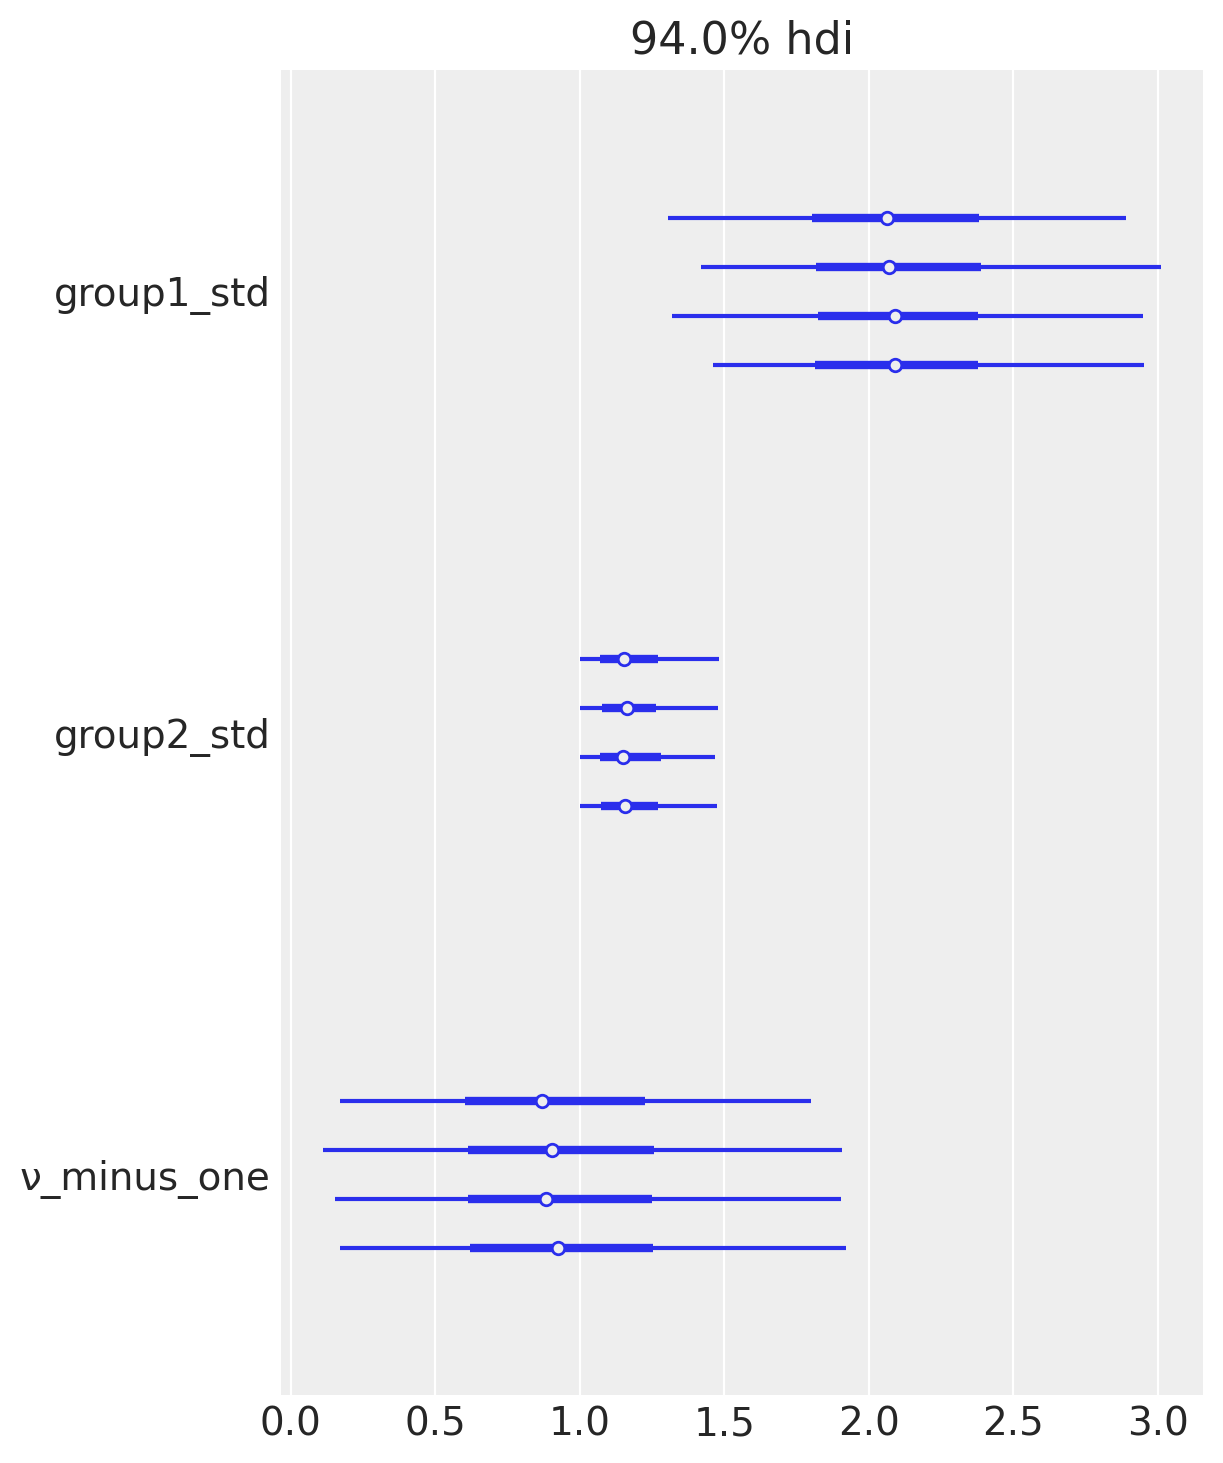

In [13]:
pm.forestplot(trace, var_names=['group1_std',
                               'group2_std',
                               'ν_minus_one']);

In [14]:
pm.summary(trace, varnames=['difference of means', 'difference of stds', 'effect size'])

/dependencies/pymc3/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,1.017,0.441,0.200,1.828,0.006,0.004,6204.0,5950.0,6226.0,5672.0,1.0
difference of stds,0.929,0.441,0.167,1.796,0.006,0.004,5063.0,5063.0,4848.0,4039.0,1.0
effect size,0.605,0.277,0.111,1.128,0.003,0.002,6387.0,6387.0,6335.0,5811.0,1.0


## References

1.	Goodman SN. Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine. 1999;130(12):995-1004. doi:10.7326/0003-4819-130-12-199906150-00008.
2.	Johnson D. The insignificance of statistical significance testing. Journal of Wildlife Management. 1999;63(3):763-772.
3.	Kruschke JK. Bayesian estimation supersedes the t test. J Exp Psychol Gen. 2013;142(2):573-603. doi:10.1037/a0029146.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by [Thomas Wiecki](https://twitter.com/twiecki) (c) 2015, updated by Chris Fonnesbeck.

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3  3.9.0
arviz  0.8.3
numpy  1.18.5
pandas 1.0.4
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
